# Simple analyses of COVID-19 disease using open data

This notebook demonstrates how to download publicly available COVID-19 case and death rates and do some simple analyses using Python Pandas.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import re
from urllib.error import HTTPError
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

## Download and index data

- [National data from the New York Times](https://www.nytimes.com/article/coronavirus-county-data-us.html)
- [Global data from Our World In Data](https://ourworldindata.org/coronavirus-source-data)

In [2]:
def process_nyt_data(url):
    """Download and format NYT data"""
    data = pd.read_csv(url)
    data.index = [pd.DatetimeIndex(data.pop('date')), data.pop('state'), data.pop('county')]
    # Remove county identifier (redundant)
    del data['fips']
    return data

NYT_DATA_URL = "https://github.com/nytimes/covid-19-data/raw/master/us-counties.csv"
nyt_data = process_nyt_data(NYT_DATA_URL)
# Display the first few table entries
nyt_data.iloc[:10]

cases  deaths
date       state      county                    
2020-01-21 Washington Snohomish        1       0
2020-01-22 Washington Snohomish        1       0
2020-01-23 Washington Snohomish        1       0
2020-01-24 Illinois   Cook             1       0
           Washington Snohomish        1       0
2020-01-25 California Orange           1       0
           Illinois   Cook             1       0
           Washington Snohomish        1       0
2020-01-26 Arizona    Maricopa         1       0
           California Los Angeles      1       0

In [3]:
date = nyt_data.index.levels[0][-1]
print("Data for {:%b %d}: {}".format(date, nyt_data.xs(date, level=0).sum().to_dict()))

Data for Apr 01: {'cases': 214682, 'deaths': 4551}


In [4]:
def process_jhu_data(url, name=None):
    """Download and format JHU data"""
    data = pd.read_csv(url)
    data.index = [data.pop('Admin2'), data.pop('Province_State')]
    data.index.names = ['county', 'state']
    for k in "UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,Combined_Key,Population".split(','):
        try:
            del data[k]
        except KeyError:
            pass
    data.columns = pd.DatetimeIndex(data.columns, name='date')
    data = data.stack().swaplevel('date', 'county').sort_index()
    data[data == 0] = np.nan
    data.name = name
    return data

JHU_US_DATA_URL = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"
jhu_cases = process_jhu_data(JHU_US_DATA_URL, name='cases')
jhu_deaths = process_jhu_data(JHU_US_DATA_URL.replace("confirmed", "deaths"), name='deaths')
jhu_data = pd.concat([jhu_cases, jhu_deaths], axis=1).dropna(how='all').fillna(0)

# Display the last few entries
date = jhu_data.index.levels[0][-1]
print("Data for {:%b %d}: {}".format(date, jhu_data.xs(date, level=0).sum().to_dict()))

Data for Apr 02: {'cases': 243453.0, 'deaths': 5926.0}


In [5]:
date = jhu_data.index.levels[0][-1]
print("Data for {:%b %d}: {}".format(date, jhu_data.xs(date, level=0).sum().to_dict()))

Data for Apr 02: {'cases': 243453.0, 'deaths': 5926.0}


In [6]:
def load_jhu_daily(dt):
    "Read a daily CSV file from the JHU repository"
    url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_daily_reports/{:%m-%d-%Y}.csv".format(dt)
    data = pd.read_csv(url)
    data.index = [[dt] * len(data.index), data.pop('Admin2'), data.pop('Province_State'), data.pop('Country_Region')]
    data.index.names = ['date', 'county', 'state', 'nation']
    data = data.swaplevel('nation', 'county').sort_index()
    return data[['Confirmed','Deaths','Recovered','Active']]

In [7]:
# See if the next day's data is available (sometimes the summary data lags)
latest_day = jhu_data.index.levels[0][-1] + pd.Timedelta(1, unit='days')

try:
    jhu_latest_day = load_jhu_daily(latest_day)
except HTTPError as e:
    print("No new data available:", str(e))
else:
    jhu_latest_day = jhu_latest_day.xs('US', level='nation')

    # Add case/death count
    temp = jhu_latest_day[['Confirmed', 'Deaths']]
    temp.columns = ['cases', 'deaths']
    jhu_data = pd.concat([jhu_data, temp], axis=0)

No new data available: HTTP Error 404: Not Found


In [8]:
# Choose JHU data instead of NYT data
US_DATA_URL = re.sub(r'/raw/.*', '', JHU_US_DATA_URL)
us_data = jhu_data
us_sum = us_data.sum(level='date')

In [9]:
# Download the international data
WORLD_DATA_URL = "https://covid.ourworldindata.org/data/ecdc/total_cases.csv"

def process_owid_data(url, name=None):
    data = pd.read_csv(url)
    data.index = pd.DatetimeIndex(data.pop('date'))
    del data['World']
    data.columns.name = 'nation'
    # Organize into [date, nation] rather than 'nation' as column
    data = data.unstack().swaplevel().sort_index()
    # Mark zeroes as unavailable
    data[data == 0] = np.nan
    data.name = name
    return data

world_cases = process_owid_data(WORLD_DATA_URL, name='cases')
world_deaths = process_owid_data(WORLD_DATA_URL.replace("cases", "deaths"), name='deaths')
world_data = pd.concat([world_cases, world_deaths], axis=1).dropna(how='all').fillna(0)
world_data.iloc[10:20]

cases  deaths
date       nation                 
2020-01-10 China      59.0     0.0
2020-01-11 China      59.0     1.0
2020-01-12 China      59.0     1.0
2020-01-13 China      59.0     1.0
           Thailand    1.0     0.0
2020-01-14 China      59.0     1.0
           Thailand    1.0     0.0
2020-01-15 China      59.0     2.0
           Japan       1.0     0.0
           Thailand    1.0     0.0

In [10]:
world_sum = world_data.sum(level='date')

In [11]:
# Construct fake data with 20% day-over-day growth rates
alpha = np.log(1 + 0.20)
fake_dates = us_data.index.levels[0]
fake = pd.Series(np.exp(alpha * np.arange(len(fake_dates))), index=fake_dates)

# Second data set has no testing done for the first 30 days while case rate rises
fake_notests = fake.copy()
fake_notests.iloc[:30] = 0

## Plot case rates and growth rates

The following function plots the actual case counts, and additionally plots a "growth rate" based on smoothed case count data. The smoother is an [exponentially weighted mean](https://pandas.pydata.org/pandas-docs/stable/user_guide/computation.html#exponentially-weighted-windows), which will preserve (asymptotically) exponential growth rates, which is the roughly the expected shape of a novel uncontrolled disease outbreak. The "fake" data demonstrates what an "ideal" infection would look like, with and without a delay in initial testing.

In [12]:
EWM_HALFLIFE = 5
SOURCE_TEXT = f"""\
USA data: {US_DATA_URL}
World data: {WORLD_DATA_URL}
Growth rate uses exp-weighted-mean ($T_{{1/2}}={EWM_HALFLIFE}$d) smoothed case counts"""

DEFAULT_STYLE = dict(linewidth=1)
STYLES = {
    'World': dict(linewidth=2, color=(.2, .8, .4)),
    'USA': dict(linewidth=1.5, color=(.2, .3, .9)),
    '20%': dict(linewidth=.75, linestyle='--', color=(.9, .5, .5)),
    '20% (delayed tests)': dict(linewidth=.75, linestyle='-.', color=(.6, .2, .1)),
    'Knox': dict(linewidth=1, color=(1, .57, 0)),
}
    
def plot_smoothed_rates(plot_data):
    fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(8,6))
    (count_ax, rate_ax) = axes
    for label, cases in plot_data.items():
        style_kwargs = STYLES.get(label, DEFAULT_STYLE)
        count_ax.semilogy(cases.index, cases, label=label, **style_kwargs)
        mean = np.array(cases.ewm(halflife=EWM_HALFLIFE).mean(), dtype=float)
        with np.errstate(divide='ignore', invalid='ignore'):
            rate = mean[1:] / mean[:-1]
        rate_ax.plot(cases.index[1:], (rate - 1) * 100, label=label, **style_kwargs)
    for ax in axes:
        ax.xaxis.set_major_locator(mdates.WeekdayLocator())
        ax.grid(zorder=0, color=(.8, .8, .8), linewidth=0.5)

    rate_ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    rate_ax.set_ylabel('Daily growth rate (%)')
    count_ax.set_ylabel('Case count')
    count_ax.legend(loc='upper left')
    ax.tick_params(axis='x', rotation=90)
    
    fig.tight_layout()
    fig.suptitle('COVID-19 cases and growth rate')
    fig.subplots_adjust(bottom=fig.subplotpars.bottom + .1, top=fig.subplotpars.top - 0.025, hspace=0)
    fig.text(.02, .02, SOURCE_TEXT, fontsize=8)
    fig.text(.98, .02, "Analysis: Seth R Johnson, Ph.D.\njohnsonsr@ornl.gov", fontsize=8, fontstyle='italic', ha='right')
    return (fig, axes)

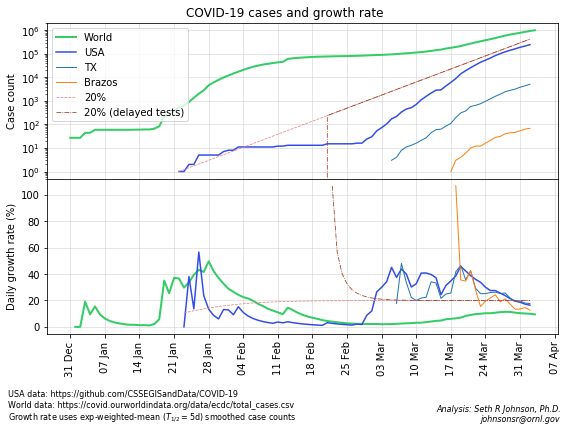

In [13]:
state_cases = us_data['cases'].xs('Texas', level="state")
plot_data = {
    'World': world_sum['cases'],
    'USA': us_sum['cases'],
    'TX': state_cases.sum(level='date'),
    'Brazos': state_cases.xs('Brazos', level='county'),
}
(fig, ax) = plot_smoothed_rates(plot_data)
fig.savefig('img/brazos.png', dpi=150)
plt.close()

# Add a plot with the fake data for comparison purposes
plot_data.update({
    '20%': fake,
    '20% (delayed tests)': fake_notests,
})      
(fig, ax) = plot_smoothed_rates(plot_data)
fig.savefig('img/brazos-plus-fake.png', dpi=150);

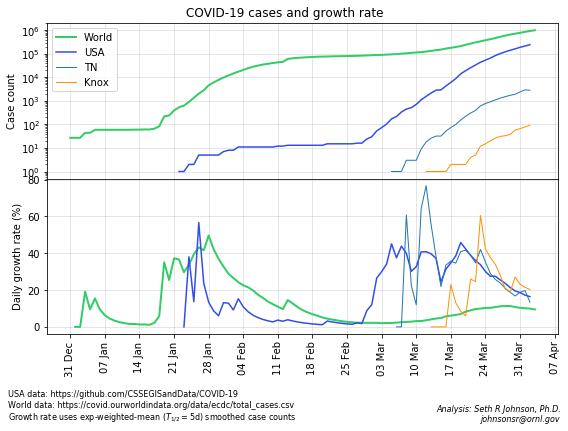

In [14]:
state_cases = us_data['cases'].xs('Tennessee', level="state")
(fig, ax) = plot_smoothed_rates({
    'World': world_sum['cases'],
    'USA': us_sum['cases'],
    'TN': state_cases.sum(level='date'),
    'Knox': state_cases.xs('Knox', level='county'),
})
fig.savefig('img/knoxville.png', dpi=150);

In [15]:
state_cases = us_data['cases'].xs('California', level="state")
(fig, ax) = plot_smoothed_rates({
    'World': world_sum['cases'],
    'USA': us_sum['cases'],
    'CA': state_cases.sum(level='date'),
    'SF': state_cases.xs('San Francisco', level='county'),
})
fig.savefig('img/san-francisco.png', dpi=150);
plt.close()

In [16]:
cases_by_state = us_data['cases'].sum(level=['date','state']).unstack()

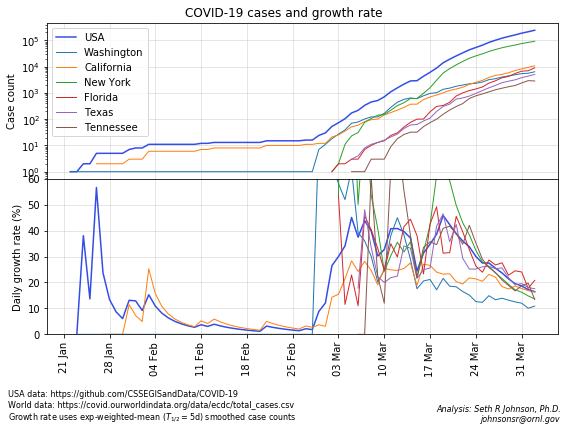

In [17]:
plot_data = {'USA': cases_by_state.sum(axis=1)}
for state in ['Washington', 'California', 'New York', 'Florida', 'Texas', 'Tennessee']:
    plot_data[state] = cases_by_state[state]
(fig, axes) = plot_smoothed_rates(plot_data)
axes[1].set_ylim([0, 60]);
fig.savefig('img/states.png', dpi=150)

In [18]:
state_cases = us_data['cases'].xs('Texas', level="state")
(fig, ax) = plot_smoothed_rates({
    'World': world_sum['cases'],
    'USA': us_sum['cases'],
    'TX': state_cases.sum(level='date'),
    'Lubbock': state_cases.xs('Lubbock', level='county'),
})
fig.savefig('img/lubbock.png', dpi=150)
plt.close()

In [19]:
state_cases = us_data['cases'].xs('Florida', level="state")
(fig, ax) = plot_smoothed_rates({
    'World': world_sum['cases'],
    'USA': us_sum['cases'],
    'FL': state_cases.sum(level='date'),
    'Polk': state_cases.xs('Polk', level='county'),
})
fig.savefig('img/lakeland.png', dpi=150)
plt.close()

## Additional plotting examples

[Pandas](https://pandas.pydata.org) has a lot of power but has a steep learning curve. These examples show a few ways to process the data above and quickly visualize using the builtin plot function.

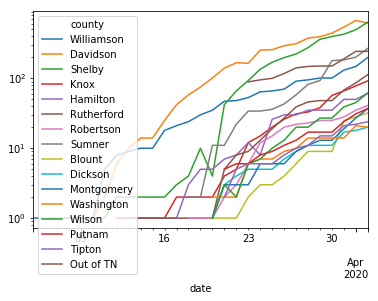

In [20]:
# Select Tennessee cases and make a table of date vs county
tenn_by_county = us_data['cases'].xs('Tennessee', level="state").unstack('county')
# Find counties with at least 20 cases at present
several_presently = tenn_by_county.iloc[-1] >= 20
# Plot those counties on a log scale
tenn_by_county.T[several_presently].T.plot(logy=True);

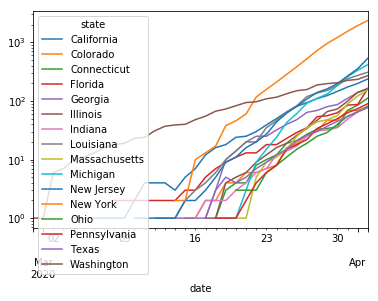

In [21]:
deaths = us_data['deaths'].sum(level=['date', 'state']).unstack('state')
many_deaths = deaths.iloc[-1] >= 50
deaths_plot = deaths.T[many_deaths].T
deaths_plot[deaths_plot == 0] = np.nan
deaths_plot.dropna(how='all').plot(logy=True);

In [22]:
EAST_TN_COUNTIES = frozenset("""\
Anderson
Bledsoe
Blount
Bradley
Campbell
Carter
Claiborne
Cocke
Cumberland
Grainger
Greene
Hamblen
Hamilton
Hancock
Hawkins
Jefferson
Johnson
Knox
Loudon
McMinn
Marion
Meigs
Monroe
Morgan
Polk
Rhea
Roane
Scott
Sevier
Sullivan
Unicoi
Union
Washington
""".splitlines())
STYLES['East TN'] = dict(linewidth=1, linestyle='-', color=(.8, .4, .3))

state_cases = us_data['cases'].xs('Tennessee', level="state")
east_tn = state_cases.unstack('county')
east_tn = east_tn[EAST_TN_COUNTIES & set(east_tn)].sum(axis=1)

In [23]:
(fig, axes) = plot_smoothed_rates({
    'World': world_sum['cases'],
    'USA': us_sum['cases'],
    'TN': state_cases.sum(level='date'),
    'East TN': east_tn,
    'Knox': state_cases.xs('Knox', level='county'),
    'Anderson': state_cases.xs('Anderson', level='county'),
    'Blount': state_cases.xs('Blount', level='county'),
})
axes[1].set_ylim(0,80)
fig.savefig('img/east-tn.pdf', dpi=150)
plt.close();